In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
examples_file_name = '/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/Input/TrainingExamples_25k.npy'
labels_file_name = '/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/Input/Labels_25k.npy'
x = np.load(examples_file_name)
y = np.load(labels_file_name)

In [3]:
num_folds=10

In [4]:
num_folds=10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7634)
skf.get_n_splits(x, y)

10

In [5]:
print(skf)

StratifiedKFold(n_splits=10, random_state=7634, shuffle=True)


### Model notes
1) he initialization?

In [6]:
def get_model(width=10, height=10, depth=13):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=10, height=10, depth=13)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10, 13, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 9, 9, 12, 64)      576       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 4, 6, 64)      0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 2, 4, 64)       110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 1, 2, 64)      0         
 3D)                                                             
                                                                 
 global_average_pooling3d (G  (None, 64)               0     

2023-10-13 15:54:57.111415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:54:57.724310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37205 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#model.compile(
#    loss="binary_crossentropy",
#    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#    metrics=["acc"],
#)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "ppp_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 50
trainingAccuracies = []
validationAccuracies = []

for fold, (train_indices, val_indices) in enumerate(skf.split(x, y)):
    print(f'Fold {fold+1}/{num_folds}:')
    
    xTrain, xVal = x[train_indices], x[val_indices]
    yTrain, yVal = y[train_indices], y[val_indices]
    
    
    model = get_model(width=10, height=10, depth=13)
    
    model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    )
    
    model.fit(
        x=xTrain,
        y=yTrain,
        validation_data = (xVal, yVal),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        #callbacks=[checkpoint_cb, early_stopping_cb],
    )
    
    y_val_pred = model.predict(xVal)
    y_val_pred_classes = np.round(y_val_pred).flatten() 
    val_accuracy = accuracy_score(yVal, y_val_pred_classes)
    print(f'Validation accuracy for fold {fold+1}: {val_accuracy}')
    
    y_train_pred = model.predict(xTrain)
    y_train_pred_classes = np.round(y_train_pred).flatten()
    train_accuracy = accuracy_score(yTrain, y_train_pred_classes)
    
    trainingAccuracies.append(train_accuracy)
    validationAccuracies.append(val_accuracy)
    
    #model.reset_weights()
    keras.backend.clear_session()

Fold 1/10:
Epoch 1/50
1407/1407 - 3s - loss: 0.2801 - acc: 0.9272 - val_loss: 0.1335 - val_acc: 0.9634 - 3s/epoch - 2ms/step
Epoch 2/50
1407/1407 - 3s - loss: 0.1231 - acc: 0.9665 - val_loss: 0.1175 - val_acc: 0.9680 - 3s/epoch - 2ms/step
Epoch 3/50
1407/1407 - 3s - loss: 0.1127 - acc: 0.9700 - val_loss: 0.1093 - val_acc: 0.9698 - 3s/epoch - 2ms/step
Epoch 4/50
1407/1407 - 3s - loss: 0.1065 - acc: 0.9717 - val_loss: 0.1047 - val_acc: 0.9708 - 3s/epoch - 2ms/step
Epoch 5/50
1407/1407 - 3s - loss: 0.1024 - acc: 0.9728 - val_loss: 0.1034 - val_acc: 0.9714 - 3s/epoch - 2ms/step
Epoch 6/50
1407/1407 - 3s - loss: 0.0998 - acc: 0.9731 - val_loss: 0.1005 - val_acc: 0.9726 - 3s/epoch - 2ms/step
Epoch 7/50
1407/1407 - 3s - loss: 0.0965 - acc: 0.9738 - val_loss: 0.0970 - val_acc: 0.9732 - 3s/epoch - 2ms/step
Epoch 8/50
1407/1407 - 3s - loss: 0.0944 - acc: 0.9742 - val_loss: 0.0919 - val_acc: 0.9738 - 3s/epoch - 2ms/step
Epoch 9/50
1407/1407 - 3s - loss: 0.0925 - acc: 0.9744 - val_loss: 0.0929 - v

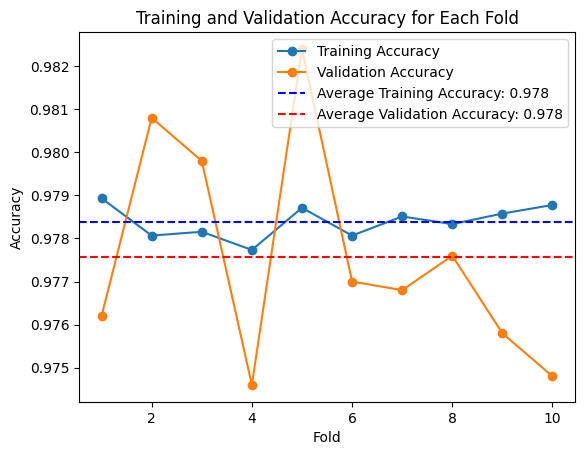

In [8]:
avg_train_accuracy = np.mean(trainingAccuracies)
avg_val_accuracy = np.mean(validationAccuracies)

# Plotting the accuracies for each fold
folds = range(1, num_folds + 1)
plt.plot(folds, trainingAccuracies, label='Training Accuracy', marker='o')
plt.plot(folds, validationAccuracies, label='Validation Accuracy', marker='o')

# Plotting average accuracies
plt.axhline(avg_train_accuracy, color='blue', linestyle='--', label=f'Average Training Accuracy: {avg_train_accuracy:.3f}')
plt.axhline(avg_val_accuracy, color='red', linestyle='--', label=f'Average Validation Accuracy: {avg_val_accuracy:.3f}')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Each Fold')
plt.legend()
plt.show()

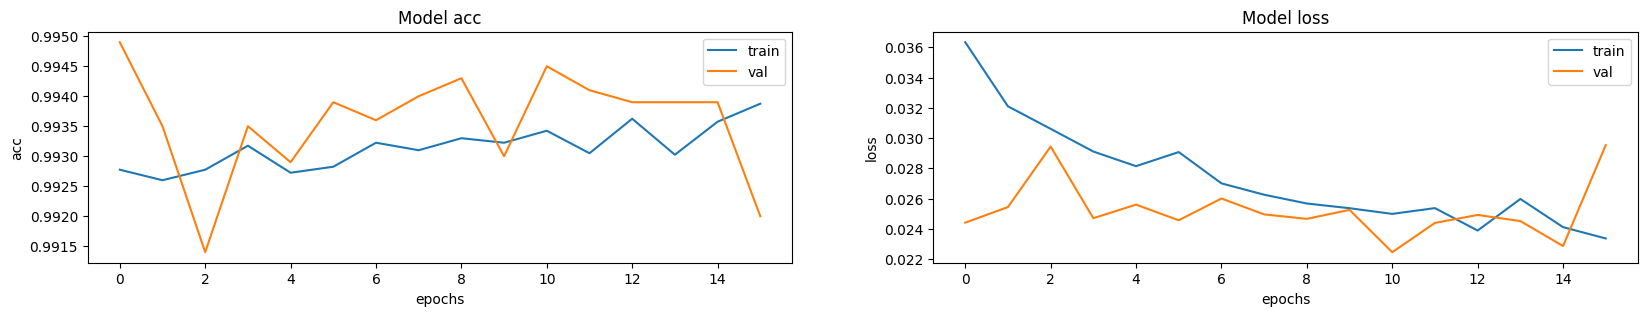

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [9]:
model2 = keras.models.load_model('/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/3d_image_classification.h5')

In [28]:
y_pred_probs = model.predict(xVal)

313/313 [==============================] - 1s 2ms/step


Text(0.5, 0, 'Prediction probability for ppp decay')

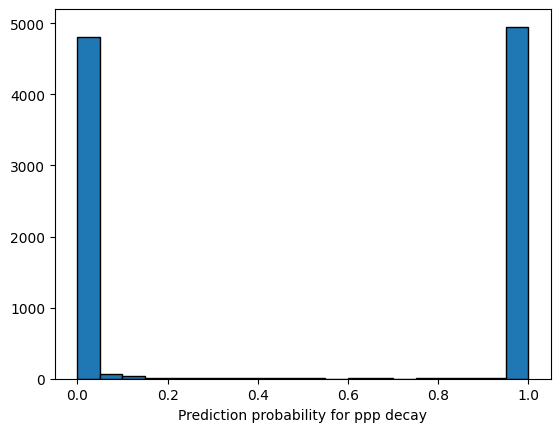

In [29]:
plt.hist(y_pred_probs, bins=20, edgecolor='black')
plt.xlabel('Prediction probability for ppp decay')

In [30]:
yPred = y_pred_probs > 0.5
yPred = yPred.astype(int)

In [31]:
yPred

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

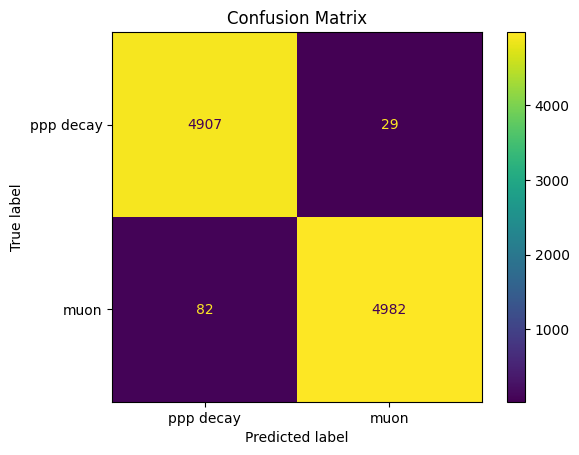

In [32]:
labels = ['ppp decay', 'muon']
cm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cmScaled, display_labels=labels)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cmScaled' is not defined